In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from numpy.linalg import svd
from sklearn.utils.extmath import randomized_svd
import time

In [2]:
train_path = "./MRIscans/Training"
test_path = "./MRIscans/Testing"
val_path = "./MRIscans/Validation"

In [3]:
def load_images(data_path, data_set_type: str):
    images = []
    test_no_tumor, test_tumor = [], []
    test_no_tumor_and_labels, test_tumor_and_labels = [], []
    
    if data_set_type == "train":
        for f in os.listdir(data_path):
            if f != '.DS_Store' and f == 'tumor':
                path = os.path.join(data_path+'/', f)
                for img in os.listdir(path):
                    if img.endswith(".jpeg") or img.endswith(".jpg"):
                        img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                        # Resize images to all have same dimensions -> avoid large image data problems
                        new_img_array = cv2.resize(img_array, (224, 224), interpolation = cv2.INTER_NEAREST)
                        # normalize pixel values to be between 0 and 1
                        new_img_array = new_img_array.astype(float, copy=False)/255  
                        images.append(new_img_array)
                        
    elif data_set_type == "test":
        for f in os.listdir(data_path):
            if f != '.DS_Store' and f == 'no_tumor':
                test_no_tumor_path = os.path.join(data_path+'/', f)
                for img in os.listdir(test_no_tumor_path):
                    if img.endswith(".jpeg") or img.endswith(".jpg"):
                        img_array = cv2.imread(os.path.join(test_no_tumor_path, img), cv2.IMREAD_GRAYSCALE)
                        img_array = cv2.resize(img_array, (224, 224), interpolation = cv2.INTER_NEAREST)
                        # normalize pixel values to be between 0 and 1
                        new_img_array = img_array.astype(float, copy=False)/255 
                        
                        # Here we create a list of tuples of the images along with their respective label.
                        # 1 = no_tumor (the anomaly). 0 = tumor (non-anomalous data)
                        test_no_tumor.append(new_img_array)
                        class_1 = np.ones(len(test_no_tumor))
                        test_no_tumor_and_labels = [test_no_tumor, class_1.tolist()]
                        
            
            if f == "tumor_test":
                test_tumor_path = os.path.join(data_path+'/', f)
                for img in os.listdir(test_tumor_path):
                    if img.endswith(".jpeg") or img.endswith(".jpg"):
                        img_array = cv2.imread(os.path.join(test_tumor_path, img), cv2.IMREAD_GRAYSCALE)
                        img_array = cv2.resize(img_array, (224, 224), interpolation = cv2.INTER_NEAREST)
                        # normalize pixel values to be between 0 and 1
                        new_img_array = img_array.astype(float, copy=False)/255  
                        test_tumor.append(new_img_array)
                        class_0 = np.zeros(len(test_tumor))
                        test_tumor_and_labels = [test_tumor, class_0.tolist()]
                
    else:
        for f in os.listdir(data_path):
            if f != '.DS_Store':
                validation_path = os.path.join(data_path+'/', f)
                try:
                    for img in os.listdir(os.path.abspath(validation_path)):
                        
                        if img.endswith(".jpeg") or img.endswith(".jpg"):
                            img_array = cv2.imread(os.path.join(validation_path, img), cv2.IMREAD_GRAYSCALE)
                            new_img_array = cv2.resize(img_array, (224, 224), interpolation = cv2.INTER_NEAREST)
                            # normalize pixel values to be between 0 and 1
                            new_img_array = new_img_array.astype(float, copy=False)/255  
                            images.append(new_img_array)
                except Exception as e:
                    raise e

                    
    return images, test_no_tumor_and_labels, test_tumor_and_labels

In [4]:
train_data, _, _ = load_images(train_path, 'train')


# test_no_labels and test_yes_labels are lists of two lists. 
# The first list contains the images. The second list contains the class label
_, test_no_labels, test_yes_labels = load_images(test_path, 'test')

In [5]:
len(test_no_labels[1])

2633

Number of training samples: 5291; Number of test samples: 3978


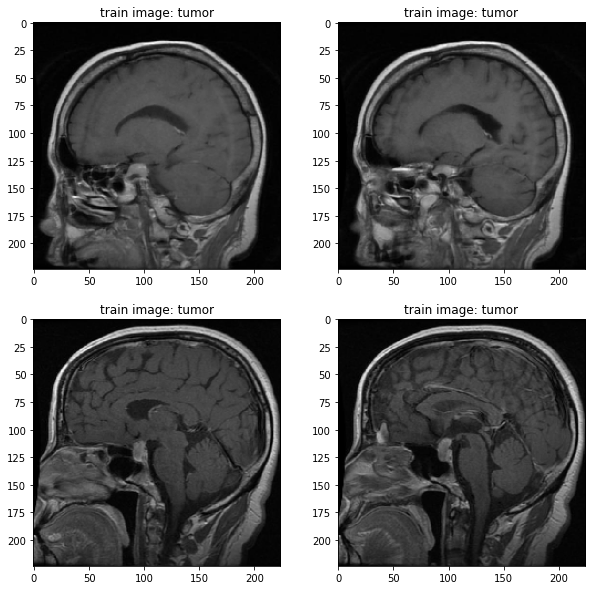

In [6]:
n_train_examples, n_test_examples = len(train_data), len(test_no_labels[0]) + len(test_yes_labels[0])
print(f"Number of training samples: {n_train_examples}; Number of test samples: {n_test_examples}")

# Plot some images from train and test sets
train_imgs = train_data[0:5]
test_imgs = test_no_labels[0][0:5]


plt.figure(figsize=(10, 10))
l =2
w = 2
for i in range(l*w):
    plt.subplot(l, w, i+1)
    plt.grid(False)
    plt.imshow(train_imgs[i], cmap='gray')
    plt.axis('on')
    plt.title("train image: tumor")

plt.show()

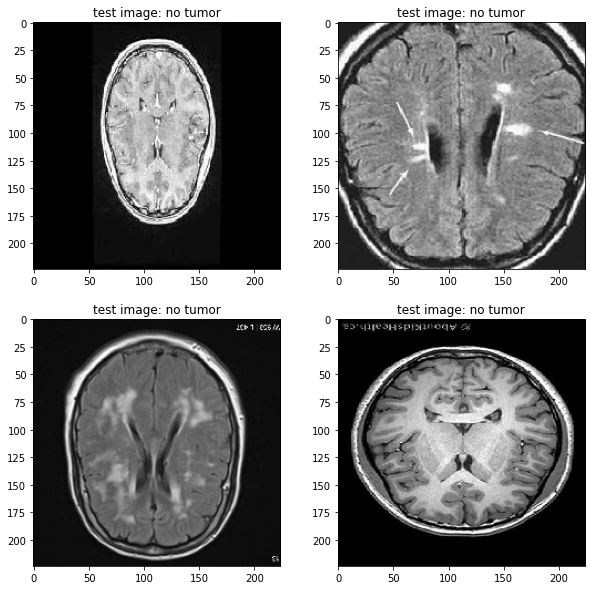

In [7]:
plt.figure(figsize=(10, 10))
l =2
w = 2
for i in range(l*w):
    plt.subplot(l, w, i+1)
    plt.grid(False)
    plt.imshow(test_imgs[i], cmap='gray')
    plt.axis('on')
    plt.title("test image: no tumor")

plt.show()

# Start Preprocessing

- Standardization: scale pixel values to have 0 mean and unit variance
- Noise reduction: remove any noise if present using cv2. ref: https://docs.opencv.org/3.4/d5/d69/tutorial_py_non_local_means.html
- Additional preprocessing steps...

# Randomized SVD

In [8]:
# SVD vs randSVD for 1 image
A = train_data[320]

# regular svd
start = time.time()
U1, S1, V1 = svd(A)
end = time.time()
print('Reg SVD: ', end-start)

# randomized svd
start = time.time()
U2, S2, V2 = randomized_svd(A, n_components=30, random_state=0)
end = time.time()
print('Rnd SVD: ', end-start)

Reg SVD:  0.03684878349304199
Rnd SVD:  0.03763175010681152


In [9]:
# function that reconstructs images using randomized svd
def randSVD_recon(A, k, graph=False):
    U, S, V = randomized_svd(A, n_components=k, random_state=0)
    recon = np.dot(U[:,:k], V[:k,:] * S[:k].reshape(k,1))
    
    if (graph):
        _, ax = plt.subplots(1, 2, figsize=(10,6))
        
        ax[0].imshow(A, cmap='gray')
        ax[0].axis('off')
        ax[0].set_title('Original image')
        
        ax[1].imshow(recon, cmap='gray')
        ax[1].axis('off')
        ax[1].set_title(f'Compressed image with rank {k}')
    
        plt.show()
    
    return recon

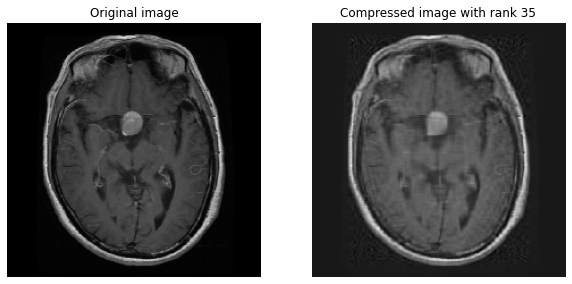

In [10]:
_ = randSVD_recon(train_data[320], k=35, graph=True)

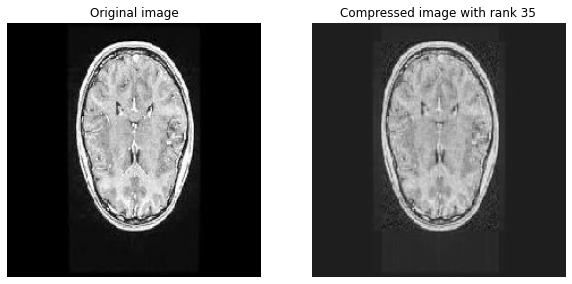

In [11]:
_ = randSVD_recon(test_imgs[0], k=35, graph=True)

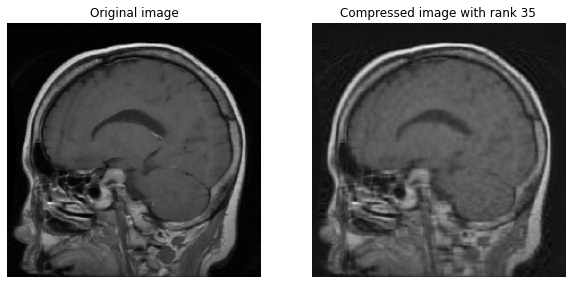

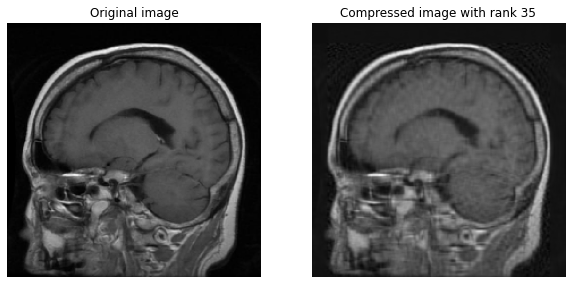

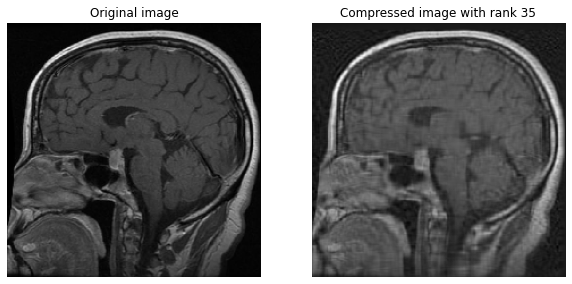

randSVD on training set: 56.95523691177368


In [12]:
# running reconstructor on all training images
graph_cond = True
start = time.time()
for i in range(len(train_data)):
    _ = randSVD_recon(train_data[i], k=35, graph=graph_cond)
    
    if i==2: graph_cond = False
end = time.time()
print('randSVD on training set:', end-start)